In [1]:
# Import the required libraries and dependencies
import pandas as pd
import datetime as dt
from prophet import Prophet
import matplotlib.pyplot as plt
from datetime import datetime
import pytz

%matplotlib inline

In [2]:
# Read census data for years 2000 - 2010
df_census_2000_2010 = pd.read_csv ('data/census_2000-2010.csv')
display ( df_census_2000_2010 )

,SUMLEV,STATE,COUNTY,PLACE,COUSUB,NAME,STNAME,ESTIMATESBASE2000,POPESTIMATE2000,POPESTIMATE2001,POPESTIMATE2002,POPESTIMATE2003,POPESTIMATE2004,POPESTIMATE2005,POPESTIMATE2006,POPESTIMATE2007,POPESTIMATE2008,POPESTIMATE2009,CENSUS2010POP,POPESTIMATE2010
0,40,1,0,0,0,Alabama,Alabama,4447207,4452173,4467634,4480089,4503491,4530729,4569805,4628981,4672840,4718206,4757938,4779736,4785298
1,162,1,0,124,0,Abbeville city,Alabama,2989,2985,2941,2909,2882,2857,2820,2807,2784,2742,2714,2688,2689
2,162,1,0,460,0,Adamsville city,Alabama,5033,5021,4960,4894,4841,4784,4728,4687,4633,4594,4558,4522,4523
3,162,1,0,484,0,Addison town,Alabama,698,701,701,708,714,722,729,741,750,752,759,758,755
4,162,1,0,676,0,Akron town,Alabama,488,485,473,454,442,426,416,404,395,384,369,356,355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81620,157,56,43,99990,0,Balance of Washakie County,Wyoming,2550,2539,2500,2490,2502,2514,2548,2550,2626,2660,2739,2786,2793
81621,50,56,45,0,0,Weston County,Wyoming,6643,6627,6487,6578,6610,6646,6594,6717,7033,7133,7266,7208,7182
81622,157,56,45,56215,0,Newcastle city,Wyoming,3313,3298,3224,3259,3268,3283,3246,3297,3471,3506,3565,3532,3520
81623,157,56,45,79125,0,Upton town,Wyoming,881,884,878,906,924,942,949,982,1034,1065,1098,1100,1096


In [3]:
#File containing data for 2000-2010 is all states, not just Ohio so create a new
#dataframe with just the data for Ohio
df_census_2000_2010_three_cs = df_census_2000_2010[( (df_census_2000_2010['STNAME'] == 'Ohio') & (((df_census_2000_2010['NAME'] == 'Columbus city') & (df_census_2000_2010['COUNTY'] == 0)) | ((df_census_2000_2010['NAME'] == 'Cleveland city') & (df_census_2000_2010['COUNTY'] == 0)) | (df_census_2000_2010['NAME'] == 'Cincinnati city') & (df_census_2000_2010['COUNTY'] ==0)))]

#Drop columns that we don't need - we drop 2010 because we'll get it in the next
#dataset
df_census_2000_2010_three_cs = df_census_2000_2010_three_cs.drop ( ['SUMLEV', 'STATE', 'COUNTY', 'PLACE', 'COUSUB', 'STNAME', 'ESTIMATESBASE2000', 'POPESTIMATE2010', 'CENSUS2010POP'], axis=1 )

#Rename the columns so they match the other dataframes
column_names = { 'NAME': 'Geographic Area',
                'POPESTIMATE2000': '2000',
                'POPESTIMATE2001': '2001',
                'POPESTIMATE2002': '2002',
                'POPESTIMATE2003': '2003',
                'POPESTIMATE2004': '2004',
                'POPESTIMATE2005': '2005',
                'POPESTIMATE2006': '2006',
                'POPESTIMATE2007': '2007',
                'POPESTIMATE2008': '2008',
                'POPESTIMATE2009': '2009'}
df_census_2000_2010_three_cs.rename ( columns = column_names, inplace = True )

#Reset the index
df_census_2000_2010_three_cs.reset_index ( inplace=True, drop=True )

#Rename the 'Geographic Area' values so they contain the strick city name
df_census_2000_2010_three_cs.loc[:, 'Geographic Area'] = df_census_2000_2010_three_cs['Geographic Area'].str.replace(' city', '')

#Sanity check by displaying the dataframe
display ( df_census_2000_2010_three_cs )

,Geographic Area,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009
0,Cincinnati,329898,326634,321852,317432,312648,308398,304713,301824,299145,298239
1,Cleveland,475755,468329,460375,452228,443502,433919,423831,415865,408261,401770
2,Columbus,714905,723364,728476,734215,738386,743511,751685,760224,770530,780950


In [4]:
# Read census data for years 2010 - 2019
df_census_2010_2019 = pd.read_csv ( 'data/census_2010-2019.csv', thousands=',' )

display ( df_census_2010_2019 )

,Geographic Area,Census,Estimates Base,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,"Aberdeen village, Ohio","1,638",1640,1643,1634,1622,1616,1612,1603,1604,1602,1608,1604
1,"Ada village, Ohio","5,952",5959,5967,5733,5769,5850,5838,5806,5595,5603,5550,5544
2,"Adamsville village, Ohio",114,123,123,123,123,123,123,124,123,124,124,124
3,"Addyston village, Ohio",938,945,945,943,945,948,947,945,944,942,939,936
4,"Adelphi village, Ohio",380,380,380,377,377,378,377,375,374,376,374,375
...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,"Youngstown city, Ohio","66,982",66946,66876,66556,66056,65470,65142,64687,64335,64540,64860,65469
926,"Zaleski village, Ohio",278,278,278,277,274,274,275,270,270,271,272,271
927,"Zanesfield village, Ohio",197,197,196,196,195,194,194,193,192,194,194,196
928,"Zanesville city, Ohio","25,487",25316,25354,25352,25247,25167,25210,25278,25182,25204,25166,25158


In [5]:
#File containing data for all incorporated places in Ohio. Filter it down to
#just Columbus, Cleveland,and Cincinnati.
df_census_2010_2019_three_cs = df_census_2010_2019[( (df_census_2010_2019['Geographic Area'] == 'Columbus city, Ohio') | (df_census_2010_2019['Geographic Area'] == 'Cleveland city, Ohio') | (df_census_2010_2019['Geographic Area'] == 'Cincinnati city, Ohio'))]
df_census_2010_2019_three_cs.reset_index ( inplace=True, drop=True )

#Drop columns that we don't need
df_census_2010_2019_three_cs = df_census_2010_2019_three_cs.drop ( ['Census', 'Estimates Base'], axis=1 )

#Rename city values in the 'Geographic Area' column so they don't include the
#word Ohio. Matching city names in all dataframes so that we can join the
#individual datasets later on.
df_census_2010_2019_three_cs.loc[:, 'Geographic Area'] = df_census_2010_2019_three_cs['Geographic Area'].str.replace(' city, Ohio', '')


display ( df_census_2010_2019_three_cs )

,Geographic Area,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Cincinnati,296980,296187,296900,297905,298626,299439,299748,301587,302277,303940
1,Cleveland,395926,392667,391550,391792,390871,389244,387662,385252,383214,381009
2,Columbus,790943,800607,812740,827797,841673,854950,866894,881694,890869,898553


In [6]:
# Read census data for years 2020 - 2023
df_census_2020_2023 = pd.read_csv ( 'data/census_2020-2023.csv', thousands=',' )
display ( df_census_2020_2023 )

,Geographic Area,"April 1, 2020\nEstimates Base",2020,2021,2022,2023
0,"Aberdeen village, Ohio",1516,1516,1518,1518,1523
1,"Ada village, Ohio",5329,5334,5170,5257,5302
2,"Adamsville village, Ohio",137,137,137,137,137
3,"Addyston village, Ohio",926,925,917,907,904
4,"Adelphi village, Ohio",318,318,317,316,316
...,...,...,...,...,...,...
920,"Youngstown city, Ohio",60047,59890,59193,59217,59108
921,"Zaleski village, Ohio",228,228,226,223,221
922,"Zanesfield village, Ohio",190,190,189,190,189
923,"Zanesville city, Ohio",24768,24774,24768,24593,24651


In [7]:
#File containing data for all incorporated places in Ohio. Filter it down to
#just Columbus, Cleveland,and Cincinnati.
df_census_2020_2023_three_cs = df_census_2020_2023[( (df_census_2020_2023['Geographic Area'] == 'Columbus city, Ohio') | (df_census_2020_2023['Geographic Area'] == 'Cleveland city, Ohio') | (df_census_2020_2023['Geographic Area'] == 'Cincinnati city, Ohio'))]
df_census_2020_2023_three_cs.reset_index ( inplace=True, drop=True )

#Drop columns that we don't need
df_census_2020_2023_three_cs = df_census_2020_2023_three_cs.drop ( ['April 1, 2020\nEstimates Base'], axis=1 )

#Rename the 'Geographic Area' so the name contains the strict city name
df_census_2020_2023_three_cs.loc[:, 'Geographic Area'] = df_census_2020_2023_three_cs['Geographic Area'].str.replace(' city, Ohio', '')


display ( df_census_2020_2023_three_cs )

,Geographic Area,2020,2021,2022,2023
0,Cincinnati,309601,308661,309405,311097
1,Cleveland,371806,365329,362806,362656
2,Columbus,906418,903184,908238,913175


<Axes: xlabel='Geographic Area'>

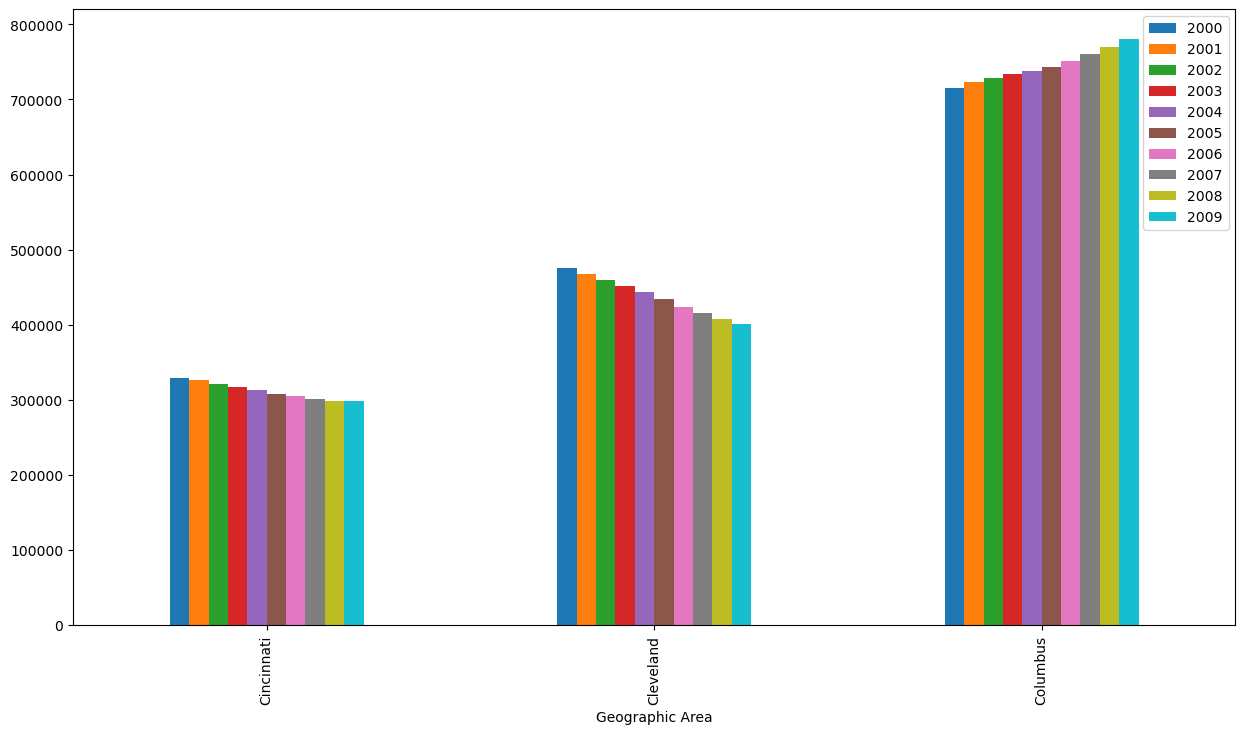

In [8]:
df_census_2000_2010_three_cs.plot ( x='Geographic Area',
                                   y=['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009'], 
                                   kind='bar',
                                   figsize= ( 15,8 ) )


<Axes: xlabel='Geographic Area'>

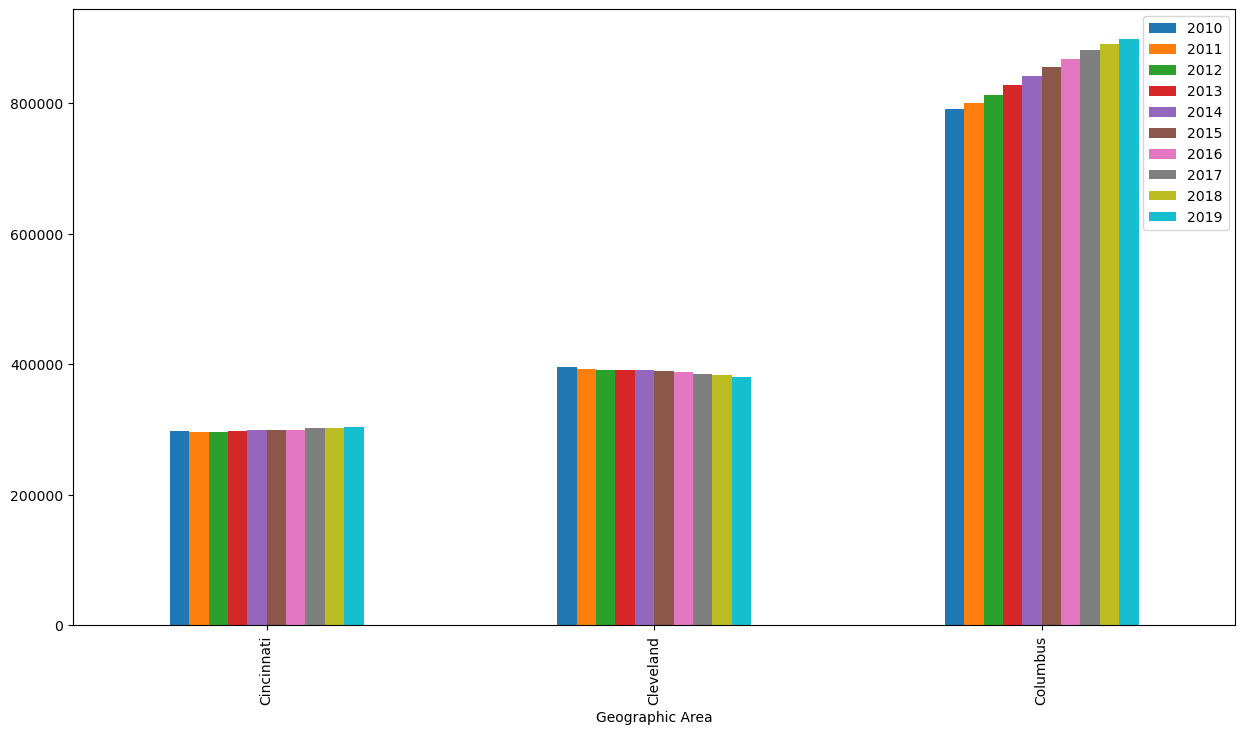

In [9]:
#df_census_2010_2019_three_cs.info ()
df_census_2010_2019_three_cs.plot ( x='Geographic Area',
                                   y=['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'], 
                                   kind='bar',
                                   figsize= ( 15,8 ) )


<Axes: xlabel='Geographic Area'>

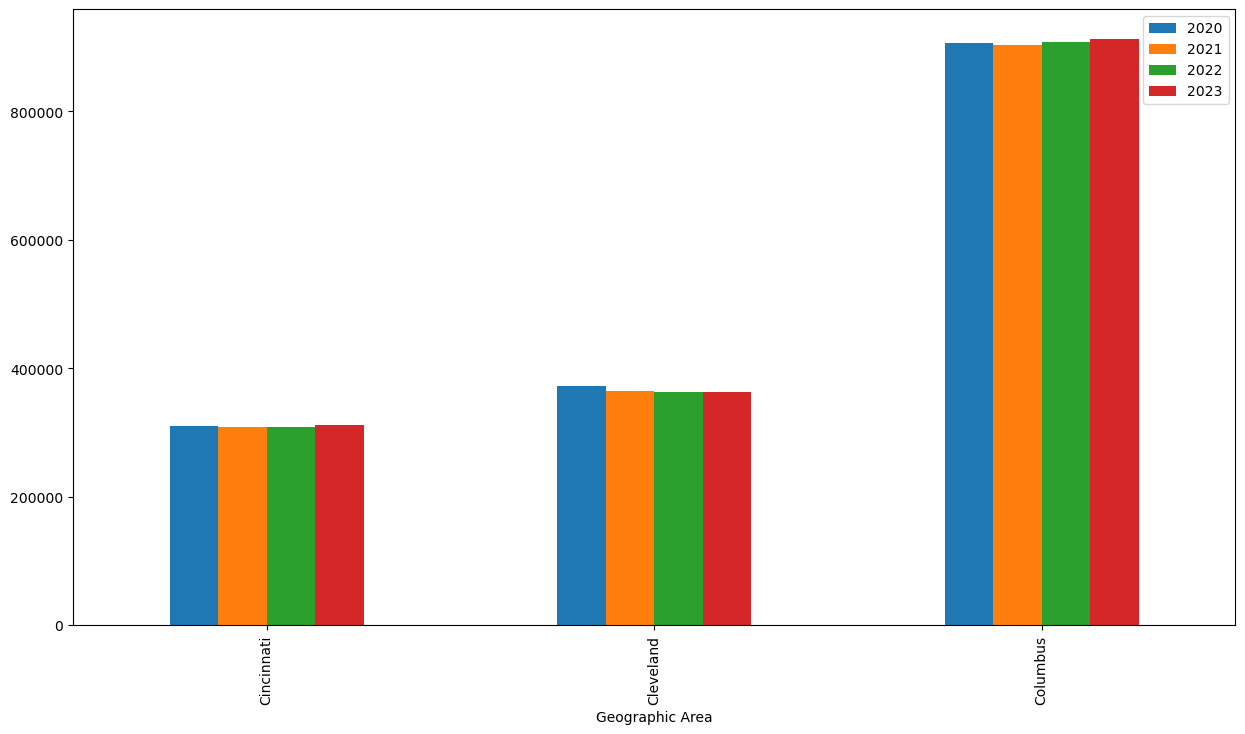

In [10]:
df_census_2020_2023_three_cs.plot ( x='Geographic Area',
                                   y=['2020', '2021', '2022', '2023'], 
                                   kind='bar',
                                   figsize= ( 15,8 ) )


In [11]:
#Combine all three dataframes together into a single dataframe
merged_inner = pd.merge(left=df_census_2000_2010_three_cs,right=df_census_2010_2019_three_cs, left_on='Geographic Area', right_on='Geographic Area')

combined_census_df = pd.merge (left=merged_inner, right=df_census_2020_2023_three_cs, left_on='Geographic Area', right_on='Geographic Area')

display ( combined_census_df )

,Geographic Area,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Cincinnati,329898,326634,321852,317432,312648,308398,304713,301824,299145,...,298626,299439,299748,301587,302277,303940,309601,308661,309405,311097
1,Cleveland,475755,468329,460375,452228,443502,433919,423831,415865,408261,...,390871,389244,387662,385252,383214,381009,371806,365329,362806,362656
2,Columbus,714905,723364,728476,734215,738386,743511,751685,760224,770530,...,841673,854950,866894,881694,890869,898553,906418,903184,908238,913175


<Axes: xlabel='Geographic Area'>

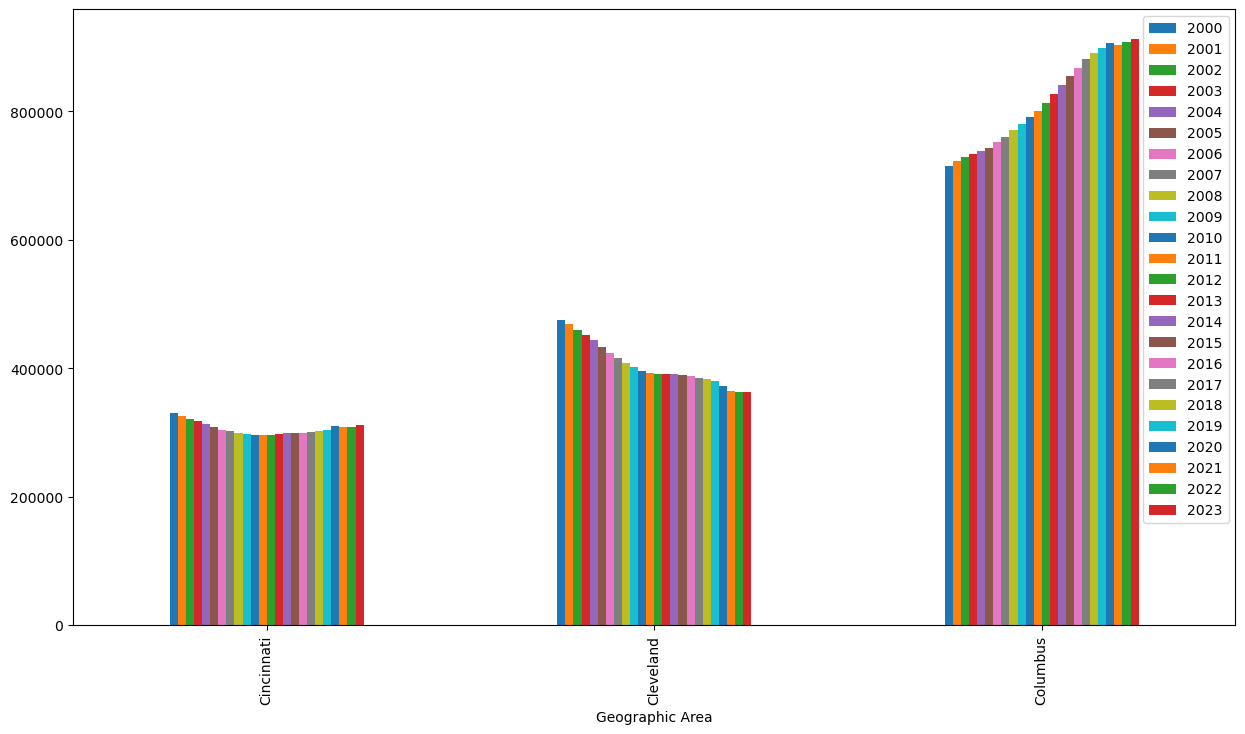

In [12]:
combined_census_df.plot ( x='Geographic Area', y=['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023'], 
                        kind='bar', figsize= ( 15,8 ) )

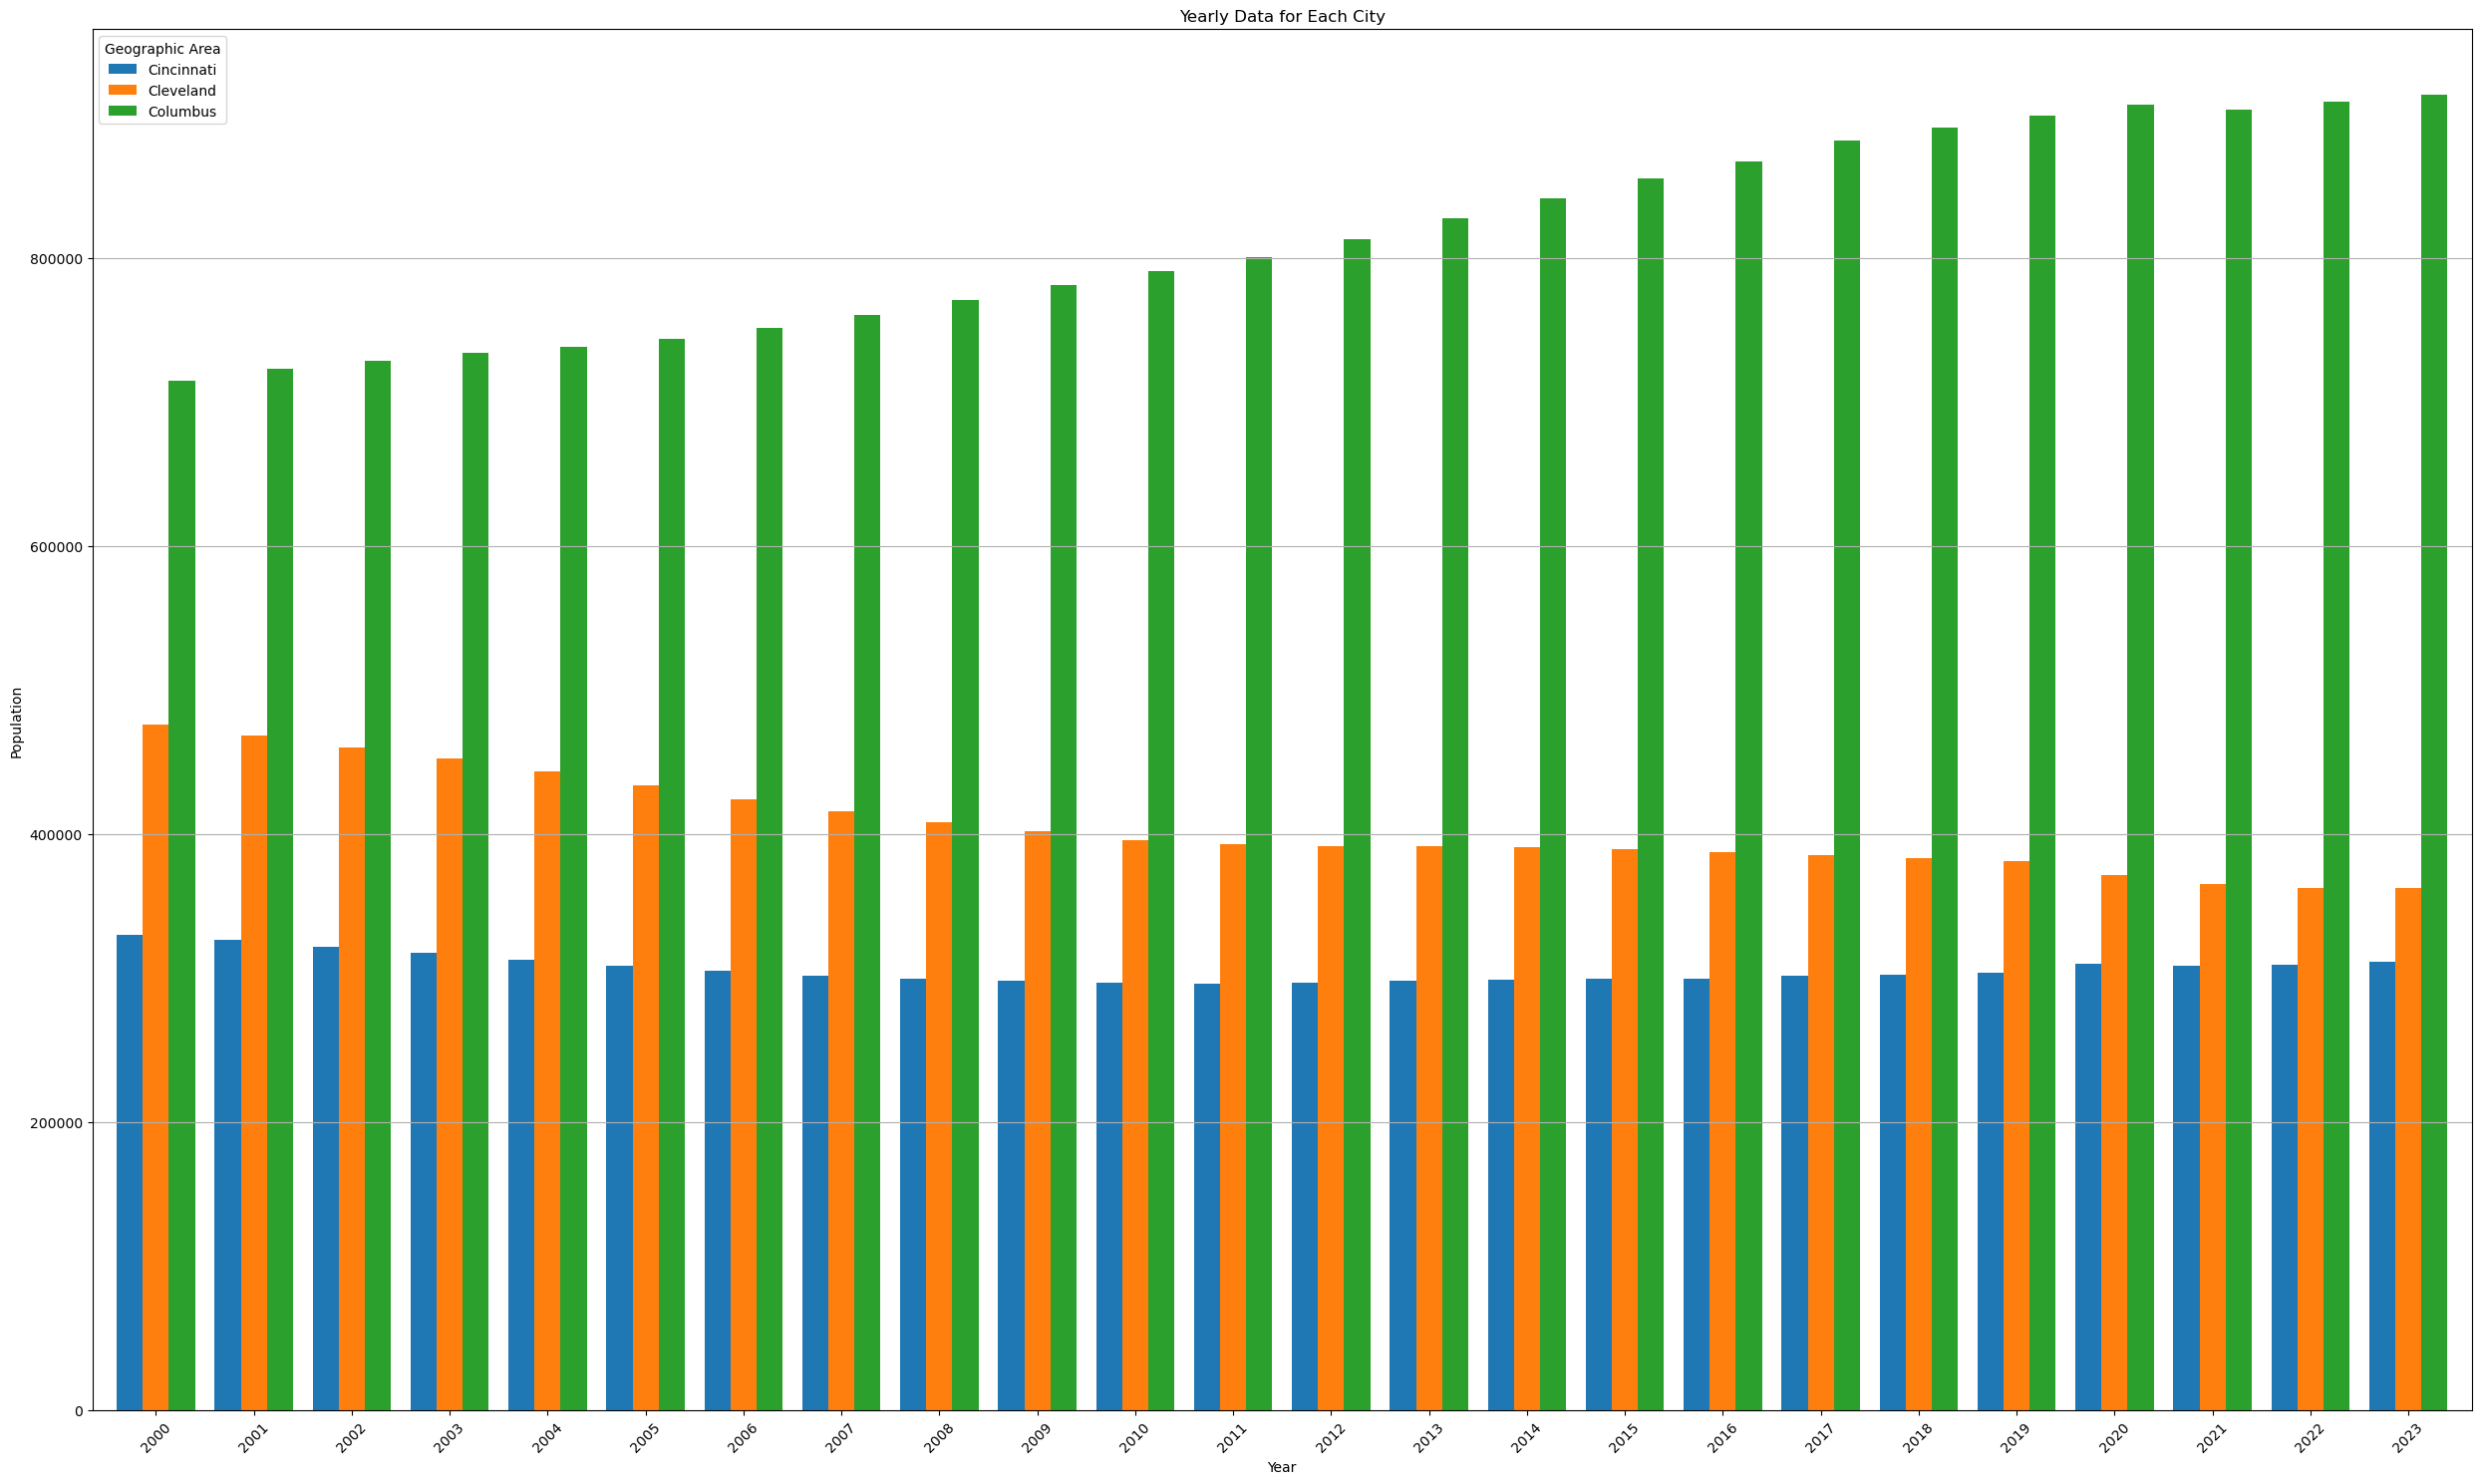

In [13]:
tmp_combined_census_df = combined_census_df.set_index ( 'Geographic Area' )

# Transpose the dataframe to have years as rows
df_transposed = tmp_combined_census_df.T

# Plotting
df_transposed.plot ( kind='bar', figsize=(25, 15), width=0.8 )
plt.title ( 'Yearly Data for Each City' )
plt.xlabel ( 'Year' )
plt.ylabel ( 'Population' )
plt.legend ( title='Geographic Area' )
plt.grid ( axis='y' )
plt.xticks ( rotation=45 )
plt.tight_layout ()
plt.show ()

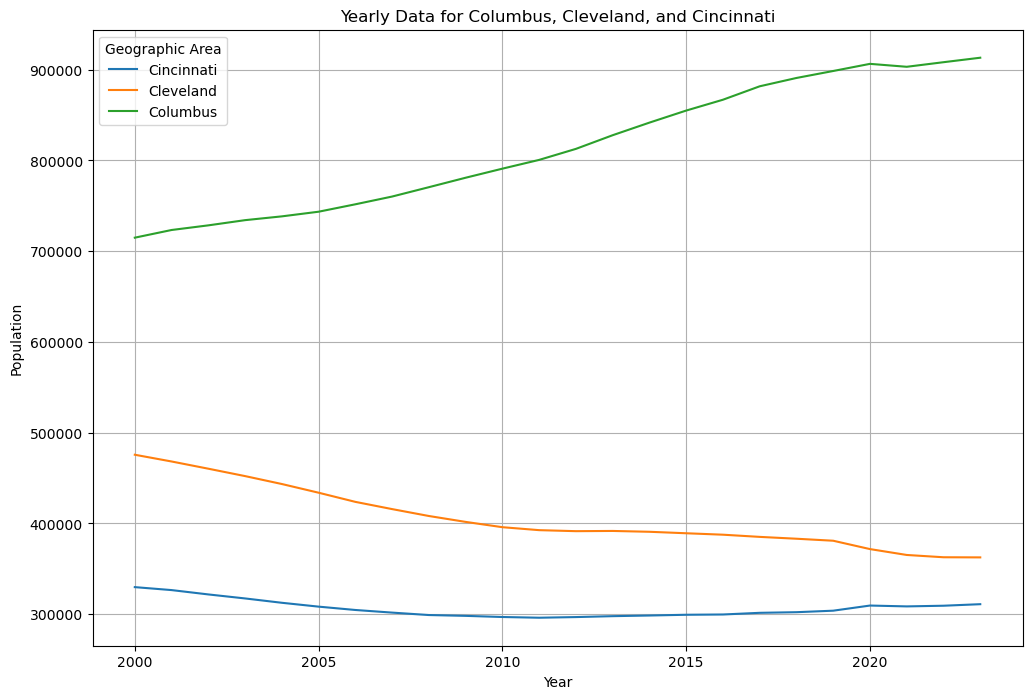

<Figure size 640x480 with 0 Axes>

In [14]:
# Plotting
df_transposed.plot(kind='line', figsize=(12, 8))
plt.title('Yearly Data for Columbus, Cleveland, and Cincinnati')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend(title='Geographic Area')
plt.grid(True)
plt.show()
plt.savefig ( "ColCleCinPop.png" )

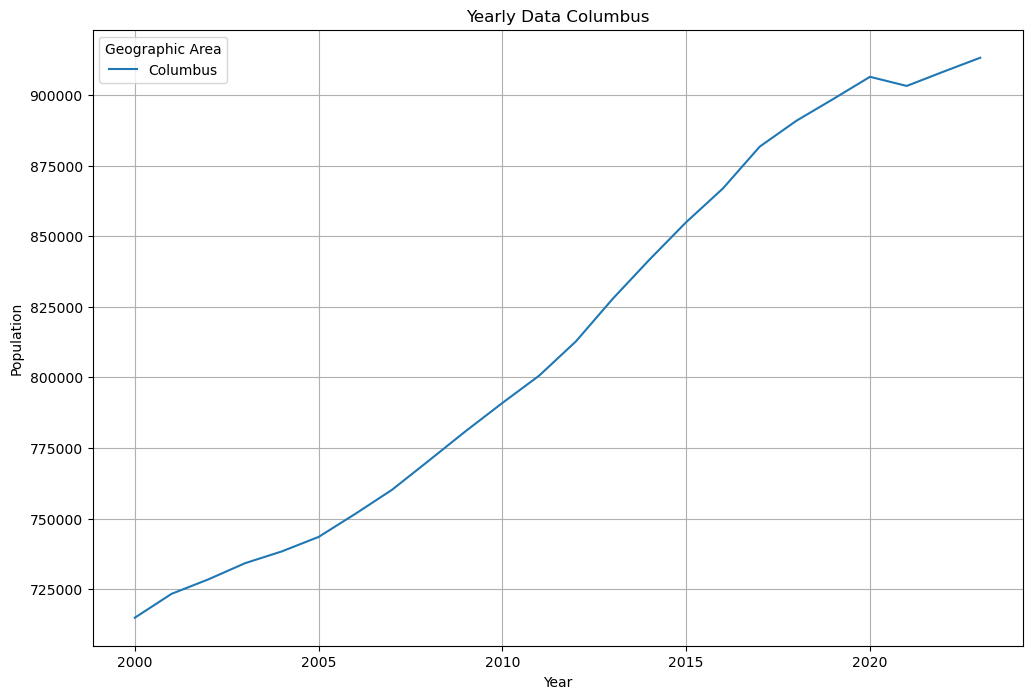

In [15]:
columbus_transposed_df = df_transposed['Columbus']

columbus_transposed_df.plot ( kind='line', figsize=(12, 8) )
plt.title ( 'Yearly Data Columbus' )
plt.xlabel ( 'Year' )
plt.ylabel ( 'Population' )
plt.legend ( title='Geographic Area' )
plt.grid ( True )
plt.show ()

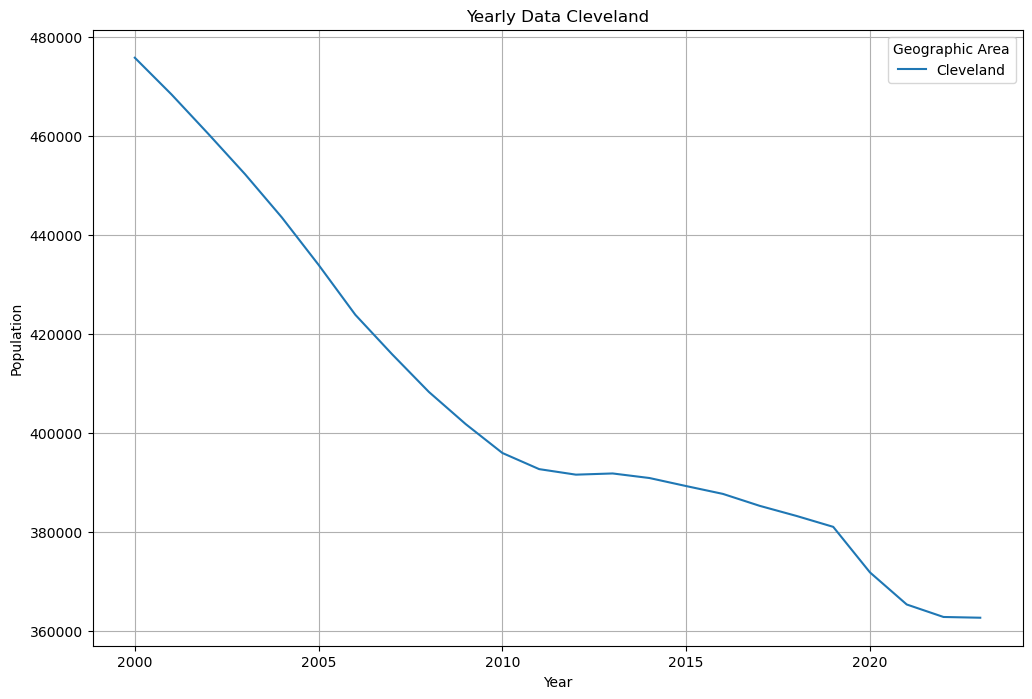

In [16]:
cleveland_transposed_df = df_transposed['Cleveland']

cleveland_transposed_df.plot ( kind='line', figsize=(12, 8) )
plt.title ( 'Yearly Data Cleveland' )
plt.xlabel ( 'Year' )
plt.ylabel ( 'Population' )
plt.legend ( title='Geographic Area' )
plt.grid ( True )
plt.show ()

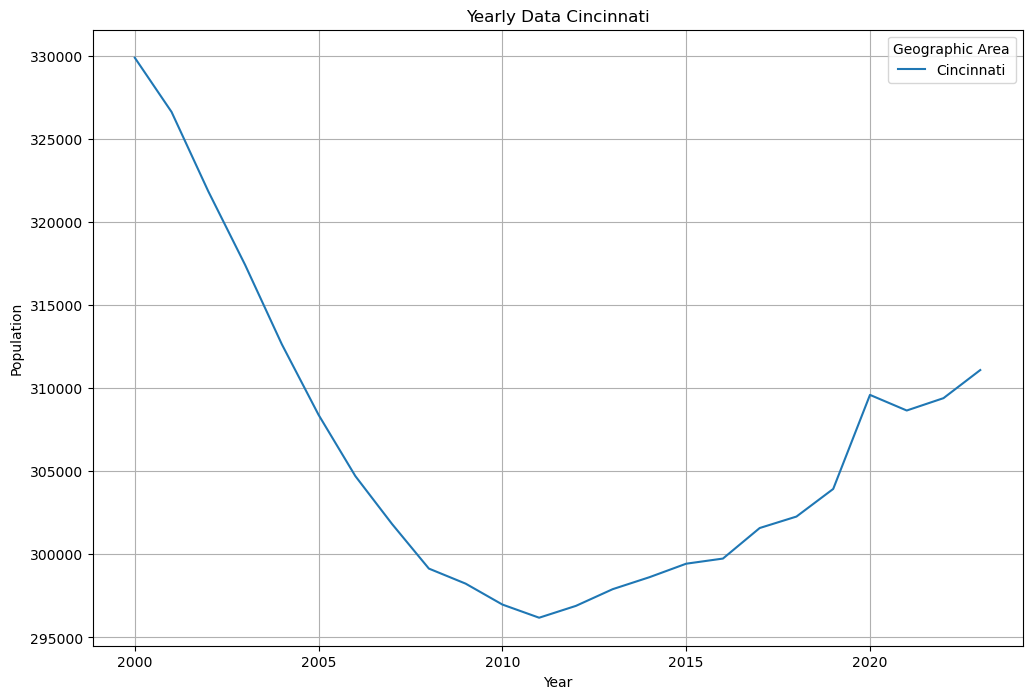

In [17]:
cincinnati_transposed_df = df_transposed['Cincinnati']

cincinnati_transposed_df.plot (kind='line', figsize=(12, 8) )
plt.title ( 'Yearly Data Cincinnati' )
plt.xlabel ( 'Year' )
plt.ylabel ( 'Population' )
plt.legend ( title='Geographic Area' )
plt.grid ( True )
plt.show ()

In [18]:
df_columbus = pd.read_csv ( "data/columbus.csv" )
df_cincinnati = pd.read_csv ( "data/cincinnati.csv" )
df_cleveland = pd.read_csv ( "data/cleveland.csv" )

def convert_to_est(timestamp):
    # Convert timestamp to datetime in UTC
    dt_utc = datetime.utcfromtimestamp(timestamp)
    
    # Specify the UTC timezone
    utc_timezone = pytz.timezone('UTC')
    
    # Localize the UTC datetime
    dt_utc = utc_timezone.localize(dt_utc)
    
    # Convert UTC datetime to Eastern Standard Time (EST)
    eastern_timezone = pytz.timezone('America/New_York')
    dt_est = dt_utc.astimezone(eastern_timezone)
    
    return dt_est

#create a column for EST
df_columbus['dt_est'] = df_columbus['dt'].apply(convert_to_est)
df_cincinnati['dt_est'] = df_cincinnati['dt'].apply(convert_to_est)
df_cleveland['dt_est'] = df_cleveland['dt'].apply(convert_to_est)

df_columbus.set_index('dt_est',inplace=True)
df_cincinnati.set_index('dt_est',inplace=True)
df_cleveland.set_index('dt_est',inplace=True)

/var/folders/7r/q8fxy3mj2hx4lvdrd4d1dfbh0000gn/T/ipykernel_94130/1242879870.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_avg_temp_columbus = columbus_2000_2023_df['temp'].resample('Y').mean()


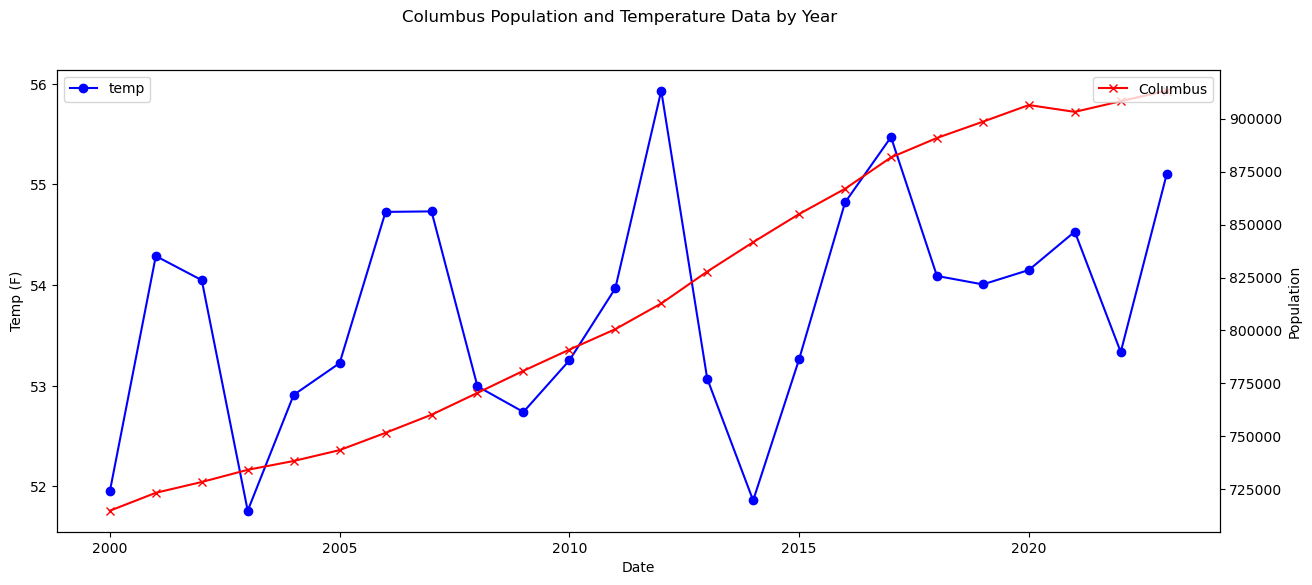

<Figure size 640x480 with 0 Axes>

In [25]:
#Graph population trends of Columbus vs average yearly temperatures
columbus_2000_2023_df = df_columbus.loc['2000-01-01':'2023-12-31', ]


fig, ax1 = plt.subplots ( figsize=(15, 6) )

# Plot population data
yearly_avg_temp_columbus = columbus_2000_2023_df['temp'].resample('Y').mean()
yearly_avg_temp_columbus = yearly_avg_temp_columbus.reset_index()

#display ( yearly_avg_temp_columbus )

yearly_avg_temp_columbus['temp'].plot ( kind='line', ax=ax1, marker='o', color=['b', 'g'] )
ax1.set_xlabel ( 'Date' )
ax1.set_ylabel ( 'Temp (F)', color='k' )
ax1.tick_params ( axis='y', labelcolor='k' )

# Create a secondary y-axis to plot temperature data
columbus_census_df = tmp_combined_census_df.loc['Columbus']
ax2 = ax1.twinx ()
columbus_census_df.plot ( kind='line', ax=ax2, marker='x', color=['r', 'c'] )
ax2.set_ylabel ( 'Population', color='k' )
ax2.tick_params ( axis='y', labelcolor='k' )

# Title and legend
fig.suptitle('Columbus Population and Temperature Data by Year')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

plt.savefig ( "ColPopTemp.png" )


In [20]:
df_columbus_transposed = columbus_census_df.T.rename_axis('year')
df_columbus_transposed = df_columbus_transposed.reset_index ()
df_columbus_transposed = df_columbus_transposed.rename (columns = {'Columbus': 'population'})

yearly_avg_temp_columbus['year'] = pd.DatetimeIndex(yearly_avg_temp_columbus['dt_est']).year
yearly_avg_temp_columbus['year'] = yearly_avg_temp_columbus['year'].astype(str)

tmp_combined = pd.merge(left=yearly_avg_temp_columbus,right=df_columbus_transposed, left_on='year', right_on='year')

tmp_combined['temp'].corr(tmp_combined['population'])


0.37252330055612004

/var/folders/7r/q8fxy3mj2hx4lvdrd4d1dfbh0000gn/T/ipykernel_94130/4059451672.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_avg_temp_cleveland = cleveland_2000_2023_df['temp'].resample('Y').mean()


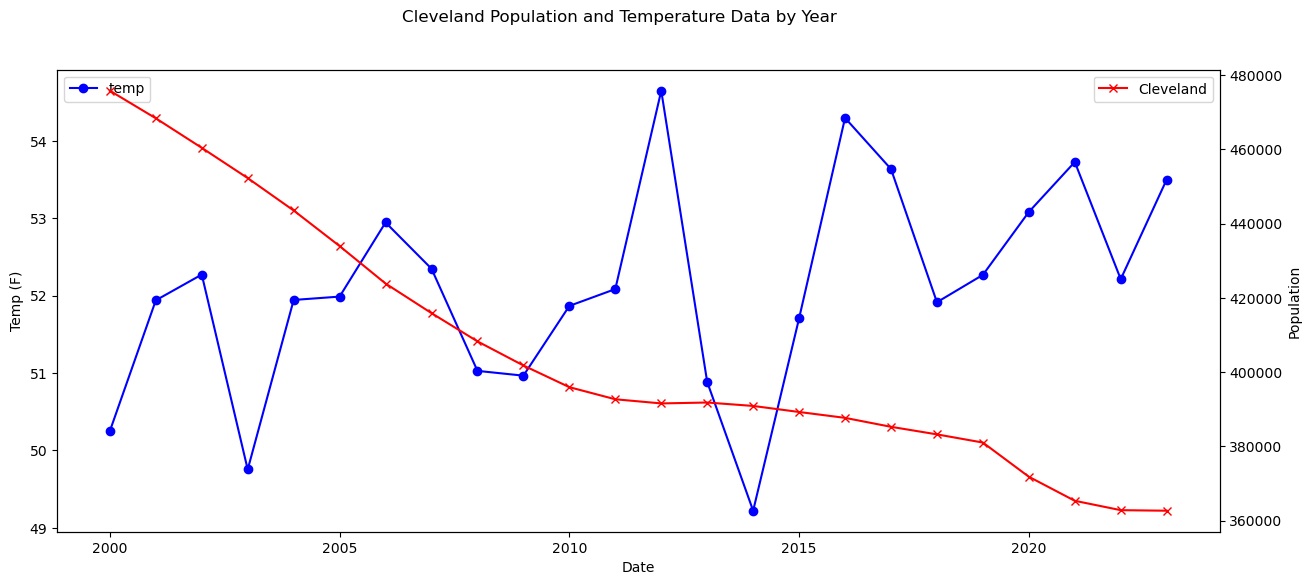

<Figure size 640x480 with 0 Axes>

In [26]:
#Graph population trends of Cleveland vs average yearly temperatures
cleveland_2000_2023_df = df_cleveland.loc['2000-01-01':'2023-12-31', ]


fig, ax1 = plt.subplots ( figsize=(15, 6) )

# Plot population data
yearly_avg_temp_cleveland = cleveland_2000_2023_df['temp'].resample('Y').mean()
yearly_avg_temp_cleveland = yearly_avg_temp_cleveland.reset_index()

#display ( yearly_avg_temp_columbus )

yearly_avg_temp_cleveland['temp'].plot ( kind='line', ax=ax1, marker='o', color=['b', 'g'] )
ax1.set_xlabel ( 'Date' )
ax1.set_ylabel ( 'Temp (F)', color='k' )
ax1.tick_params ( axis='y', labelcolor='k' )

# Create a secondary y-axis to plot temperature data
cleveland_census_df = tmp_combined_census_df.loc['Cleveland']
ax2 = ax1.twinx ()
cleveland_census_df.plot ( kind='line', ax=ax2, marker='x', color=['r', 'c'] )
ax2.set_ylabel ( 'Population', color='k' )
ax2.tick_params ( axis='y', labelcolor='k' )

# Title and legend
fig.suptitle('Cleveland Population and Temperature Data by Year')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

plt.savefig ( "ClePopTemp.png" )


In [22]:
df_cleveland_transposed = cleveland_census_df.T.rename_axis('year')
df_cleveland_transposed = df_cleveland_transposed.reset_index ()
df_cleveland_transposed = df_cleveland_transposed.rename (columns = {'Cleveland': 'population'})

yearly_avg_temp_cleveland['year'] = pd.DatetimeIndex(yearly_avg_temp_cleveland['dt_est']).year
yearly_avg_temp_cleveland['year'] = yearly_avg_temp_cleveland['year'].astype(str)

tmp_cle_combined = pd.merge(left=yearly_avg_temp_cleveland,right=df_cleveland_transposed, left_on='year', right_on='year')

tmp_cle_combined['temp'].corr(tmp_cle_combined['population'])

-0.41406852887518525

/var/folders/7r/q8fxy3mj2hx4lvdrd4d1dfbh0000gn/T/ipykernel_94130/3464485380.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_avg_temp_cincinnati = cincinnati_2000_2023_df['temp'].resample('Y').mean()


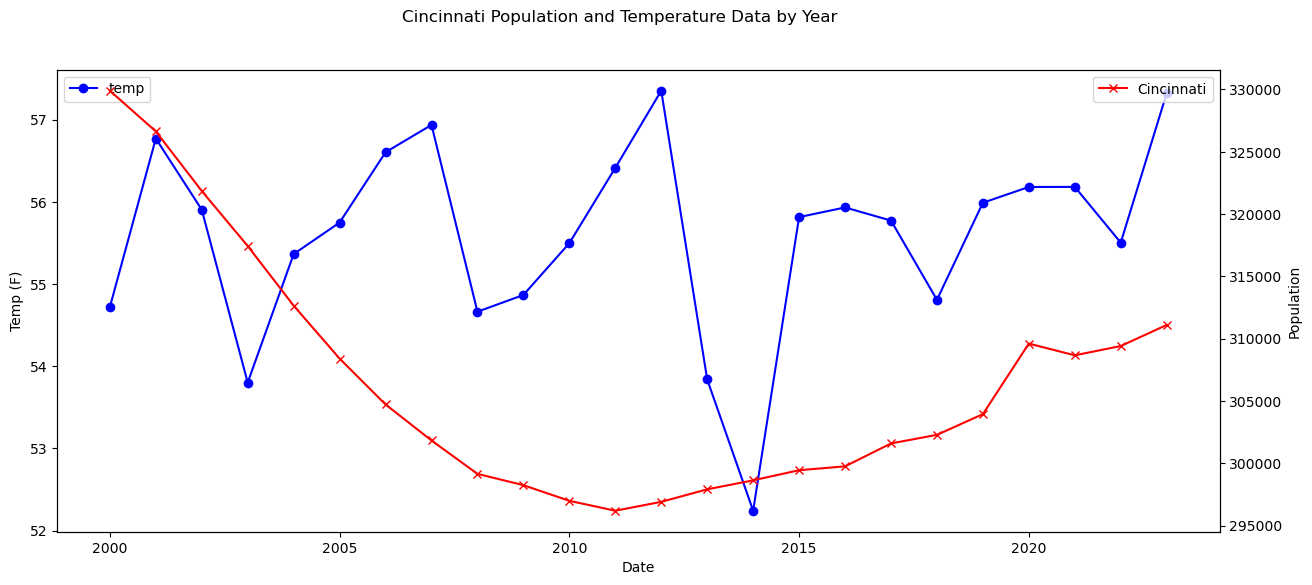

In [23]:
#Graph population trends of Cincinnati vs average yearly temperatures
cincinnati_2000_2023_df = df_cincinnati.loc['2000-01-01':'2023-12-31', ]


fig, ax1 = plt.subplots ( figsize=(15, 6) )

# Plot population data
yearly_avg_temp_cincinnati = cincinnati_2000_2023_df['temp'].resample('Y').mean()
yearly_avg_temp_cincinnati = yearly_avg_temp_cincinnati.reset_index()

#display ( yearly_avg_temp_columbus )

yearly_avg_temp_cincinnati['temp'].plot ( kind='line', ax=ax1, marker='o', color=['b', 'g'] )
ax1.set_xlabel ( 'Date' )
ax1.set_ylabel ( 'Temp (F)', color='k' )
ax1.tick_params ( axis='y', labelcolor='k' )

# Create a secondary y-axis to plot temperature data
cincinnati_census_df = tmp_combined_census_df.loc['Cincinnati']
ax2 = ax1.twinx ()
cincinnati_census_df.plot ( kind='line', ax=ax2, marker='x', color=['r', 'c'] )
ax2.set_ylabel ( 'Population', color='k' )
ax2.tick_params ( axis='y', labelcolor='k' )

# Title and legend
fig.suptitle('Cincinnati Population and Temperature Data by Year')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

plt.savefig ( "CinPopTemp.png" )


In [24]:
df_cincinnati_transposed = cincinnati_census_df.T.rename_axis('year')
df_cincinnati_transposed = df_cincinnati_transposed.reset_index ()
df_cincinnati_transposed = df_cincinnati_transposed.rename (columns = {'Cincinnati': 'population'})

yearly_avg_temp_cincinnati['year'] = pd.DatetimeIndex(yearly_avg_temp_cincinnati['dt_est']).year
yearly_avg_temp_cincinnati['year'] = yearly_avg_temp_cincinnati['year'].astype(str)

tmp_cin_combined = pd.merge(left=yearly_avg_temp_cincinnati,right=df_cincinnati_transposed, left_on='year', right_on='year')

tmp_cin_combined['temp'].corr(tmp_cin_combined['population'])

0.06679843120119518